Author: Brian Erichsen Fagundes
MSD CS 6017 - Summer - 2024
Homework 3: Scraping and Regression

Part 1 Data Acquisiton

In [40]:
from bs4 import BeautifulSoup
import pandas as pd
import urllib.request
import re


# Create arrays of data to be scraped
ranks = []
title_lengths = []
age_in_hours = []
points = []
comments_numbers = []

for i in range(5):
    url="http://news.ycombinator.com/?p=" + str(i+1)
# Access website contents
    with urllib.request.urlopen (url) as response:
        html=response.read()
        html=html.decode("utf-8")

# Saves html content into file
    with open ("hackernews" + str(i+1) + ".html", "w") as new_file:
        new_file.write(html)

# Parses html content into a soup
    soup = BeautifulSoup(html, 'html.parser')
    
# Scrapes rank data
    for post in soup.find_all(class_="rank"):
        rank = str(post.text)
        rank = rank.replace('.', '')
        ranks.append(int(rank))

# Loads length of title data
    for title in soup.find_all(class_="titleline"):
        title_lengths.append(len(title.text))

# Loads age data
    for age in soup.find_all(class_="age"):
        age_str =  str(age.text)
        age_str =  age_str.removesuffix(" hours ago")
        age_str = age_str.removesuffix(" hour ago")

        if " day ago" in age_str:
            age_in_hours.append(24)
        elif " days ago" in age_str:
            string = age_str.replace(" days ago", "")
            num = int(string)
            age_in_hours.append(num*24)
        elif " minute ago" in age_str or " minutes ago" in age_str:
            age_in_hours.append(0)
        else:
            age_in_hours.append(int(age_str))

    for subtext in soup.find_all(class_="subtext"):
        point = 0
        comments = 0
        for score in subtext.find_all(class_="score"):
            point = int(re.search(r'\d+', str(score.text)).group())

        for tag in subtext.find_all("a"):
            if tag.text.endswith("comments"):
                a_= str(tag.text)
                comments = int(re.search(r'\d+', a_).group())

        points.append(int(point))
        comments_numbers.append(int(comments))

data_frame = pd.DataFrame({
    "Rank" : ranks, "Title Length" : title_lengths, "Age (hours)" : age_in_hours,
    "Points" : points, "Comments" : comments_numbers
})
print(data_frame.head())


   Rank  Title Length  Age (hours)  Points  Comments
0     1            75            0      24         9
1     2            36            7     307        48
2     3            65            3      75        13
3     4            49            5     141        43
4     5            79            4      90        37


In [41]:
# save data into file so we don't have to load data each time
data_frame.to_csv("hacker_news_stories.csv", index=False)

Part 2 - Regression

In [42]:
import statsmodels.api as sm

dataframe = pd.read_csv("hacker_news_stories.csv")
x = data_frame['Age (hours)']
y = data_frame['Rank']

x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   Rank   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     99.40
Date:                Fri, 07 Jun 2024   Prob (F-statistic):           3.14e-18
Time:                        18:55:39   Log-Likelihood:                -739.53
No. Observations:                 150   AIC:                             1483.
Df Residuals:                     148   BIC:                             1489.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          43.9051      4.198     10.459      

In [43]:
# Multiple linear regression model - keeping all 4 variables
x = data_frame[['Comments', 'Age (hours)', 'Points', 'Title Length']]
x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   Rank   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     29.94
Date:                Fri, 07 Jun 2024   Prob (F-statistic):           3.74e-18
Time:                        18:55:39   Log-Likelihood:                -732.91
No. Observations:                 150   AIC:                             1476.
Df Residuals:                     145   BIC:                             1491.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           29.6383     10.145      2.921   

In [44]:
from sklearn.preprocessing import PolynomialFeatures

# polynomial regression model: Rank ~ Comments + Comments^2 + Title Length + Title Length^2
poly = PolynomialFeatures(degree=2, include_bias=False)
x_poly = poly.fit_transform(data_frame[['Comments', 'Title Length']])
x = pd.DataFrame(x_poly, columns=poly.get_feature_names_out(['Comments', 'Title Length']))
x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   Rank   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     1.749
Date:                Fri, 07 Jun 2024   Prob (F-statistic):              0.127
Time:                        18:55:39   Log-Likelihood:                -773.64
No. Observations:                 150   AIC:                             1559.
Df Residuals:                     144   BIC:                             1577.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    93.27

In [45]:
import numpy as np

# inverse linear model with all 4 variables for x
x = 1 / data_frame[['Comments', 'Age (hours)', 'Points', 'Title Length']]
x = sm.add_constant(x.replace([np.inf, -np.inf], 0))
model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   Rank   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     6.787
Date:                Fri, 07 Jun 2024   Prob (F-statistic):           4.91e-05
Time:                        18:55:39   Log-Likelihood:                -765.19
No. Observations:                 150   AIC:                             1540.
Df Residuals:                     145   BIC:                             1555.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           97.9832     10.299      9.513   

In [46]:
import numpy as np

# inverse linear model keeping only points for x variable
x = 1 / data_frame[['Points']]
x = sm.add_constant(x.replace([np.inf, -np.inf], 0))
model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   Rank   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                  0.001020
Date:                Fri, 07 Jun 2024   Prob (F-statistic):              0.975
Time:                        18:55:39   Log-Likelihood:                -778.06
No. Observations:                 150   AIC:                             1560.
Df Residuals:                     148   BIC:                             1566.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         75.4150      4.444     16.970      0.0

Explore several possible least squares regressions to predict a story's rank based on the other variables.

- The model rank ~ Age. R^2 = 0.402 and p value of 0.00 meaning that is this model alone where we hold all other variables constant and compare the likely of the variable age to impact the total rank is significant and it has a direct correlation.

- However, when we put all the data's variables in the same model where rank ~ Comments + Age (hours) + Points + Title Length. R^2 = 0.452 where the variable age has a p value of 0.00 meaning that the older a post is more likely that it will have a higher rank number.
The variable that seems to have the lowest impact on rank seems to be points since it has a negative coefficient of -0.0474 meaning that for each point increase there is a decrease in rank by approximately 0.5 units of rank.

- The inverse linear model where rank ~ 1 / Comments + Age (hours) + Points + Title Length has R^2 = 0.158. The variable points has a p value of 0.00 meaning that per collected with 0.01% significance level we can assume that points have a inverse relationship with rank. Age variable has p a value of 0.00 where its coefficient has a value of -87.6466 meaning that older posts tends to increase the rank.

The model that seems the to be the best fit for the collected data is the multiple linear regression with a R-squared (0.452) compared to inverse model and quadratic model as well.

Part 3 Classification

In [47]:
import numpy as np
from sklearn.model_selection import train_test_split

# np where returns elements from x or y (condition, x, y)
# x = true and y = false
# last rank seem in the 1st page is 30- 1 for front page and 0 for not
data_frame['Front Page'] = np.where(data_frame['Rank'] <= 30, 1, 0)

# keep all variables in the model
x = data_frame[['Comments', 'Age (hours)', 'Points', 'Title Length']]
y = data_frame['Front Page']

# Defines intercept beta 0
x = sm.add_constant(x)

# Splits the data into training and testing sets
# splits random train and test subsets ~ 30% into test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Fits the logit regression model
logit_model = sm.Logit(y_train, x_train)
result = logit_model.fit()

# Prints summary for analysis
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.268563
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:             Front Page   No. Observations:                  105
Model:                          Logit   Df Residuals:                      100
Method:                           MLE   Df Model:                            4
Date:                Fri, 07 Jun 2024   Pseudo R-squ.:                  0.3935
Time:                        18:55:39   Log-Likelihood:                -28.199
converged:                       True   LL-Null:                       -46.496
Covariance Type:            nonrobust   LLR p-value:                 2.185e-07
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.7737      1.428      1.942      0.052      -0.025       5.572
Comments         0.0068

[[29  3]
 [10  3]]
              precision    recall  f1-score   support

           0       0.74      0.91      0.82        32
           1       0.50      0.23      0.32        13

    accuracy                           0.71        45
   macro avg       0.62      0.57      0.57        45
weighted avg       0.67      0.71      0.67        45

Accuracy:  0.7111111111111111
Optimization terminated successfully.
         Current function value: 0.494401
         Iterations 6


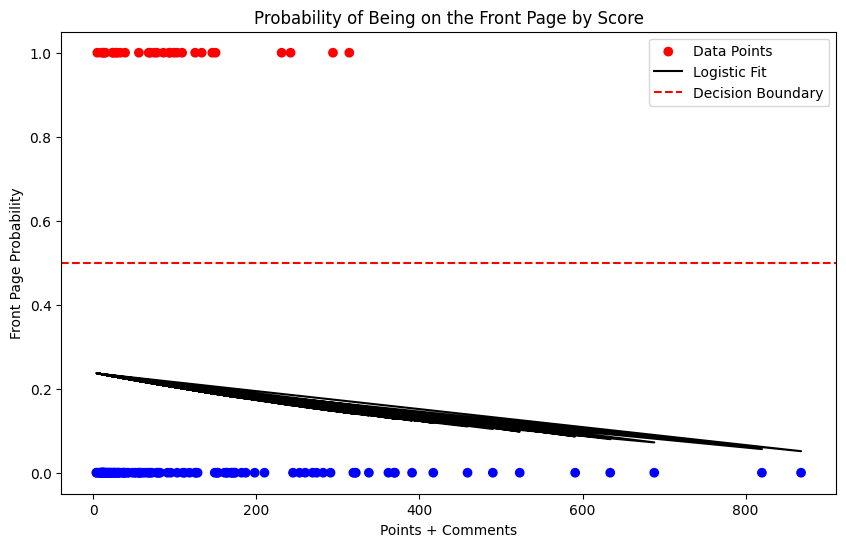

                           Logit Regression Results                           
Dep. Variable:             Front Page   No. Observations:                  150
Model:                          Logit   Df Residuals:                      148
Method:                           MLE   Df Model:                            1
Date:                Fri, 07 Jun 2024   Pseudo R-squ.:                 0.01199
Time:                        20:23:32   Log-Likelihood:                -74.160
converged:                       True   LL-Null:                       -75.060
Covariance Type:            nonrobust   LLR p-value:                    0.1796
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1612      0.262     -4.437      0.000      -1.674      -0.648
Score         -0.0020      0.002     -1.223      0.221      -0.005       0.001


In [70]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
# Predicts the probability and class labels
y_pred_prob = result.predict(x_test)
y_pred = np.where(y_pred_prob > 0.5, 1, 0)

# prints accuracy key points
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))

# plots regression for multi linear data points + age
data_frame['Score'] = (data_frame['Points'] + data_frame['Age (hours)'])
logit_model2 = sm.Logit(data_frame['Front Page'], sm.add_constant(data_frame['Score']))
result2 = logit_model2.fit()
# plots regression
plt.figure(figsize=(10, 6))
plt.scatter(data_frame['Score'], data_frame['Front Page'], c=['red' if z else 'blue' for z in data_frame['Front Page']], label='Data Points')
predicted_probs = result2.predict(sm.add_constant(data_frame[['Score']]))
plt.plot(data_frame['Score'], predicted_probs, color='black', label='Logistic Fit')
plt.axhline(0.5, color='red', linestyle='--', label='Decision Boundary')
plt.xlabel('Points + Comments')
plt.ylabel('Front Page Probability')
plt.title('Probability of Being on the Front Page by Score')
plt.legend()
plt.show()

print(result2.summary())


Confusion Matrix Analysis:
False positive: The model incorrectly predicted a positive class when its actually negative. 3 for False positive.
False negative: The model incorrecly predicted a negative class when its actually positive. Here, it's 10.
The model had an approximation of 71% accuracy.

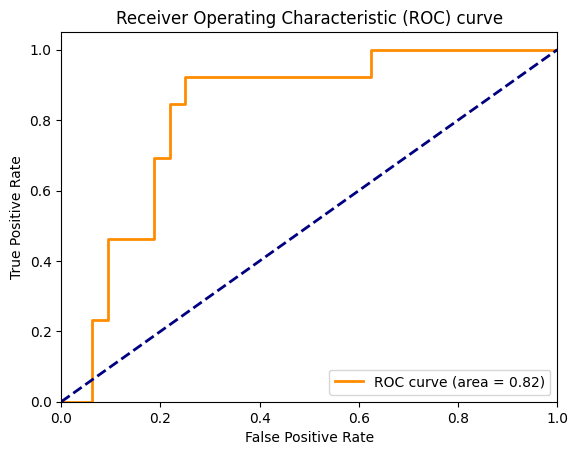

In [49]:
from sklearn.metrics import roc_curve, auc


# receiver operating characteristic curve - diagnostic ability of
# binary classifier -- auc Area under curve
# false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color = 'navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

Analysis of Regression Results:
    -The significant predictor of an article making to the front page seems to be related to age. Age variable has a p value of 0.00 with a negative coefficient meaning that the older an article gets less likely to be on the front page.